### Preliminary Actions: Read the dataset from csv file first. Then create the response variable Series. Also create a scaler

In [1]:
# There are many warnings regarding the updates in the future releases of the libraries. Ignore them.
import warnings
warnings.filterwarnings("ignore")

# Improt necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from xgboost import XGBRegressor
import seaborn as sns

# Load the data set
df = pd.read_csv('data_updated.csv')

# Convert RUCC to string
df.RUCC = df.RUCC.astype('str')

# Define response variable 
y = df['poverty_log']

# Define a scaler
scaler = StandardScaler()

In [2]:
# Define a function which receives a dataframe feature, create dummy variables, drop the dummy variables specificed by
# a parameter, and returns train and test set

def train_test(X_feature,y,dummies):
    """ This function receives the dataframe feature X_feature, create dummy variables, drop the dummy variables specificed by
    dummies parameters, split X_feature and y to train and test sets, and returns train and test set"""
    X = pd.get_dummies(X_feature)
    X.drop(dummies,axis=1,inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=21)
    return X_train, X_test, y_train, y_test    

### Build a linear model

#### Run 5-fold cross-validation

In [13]:
# define the features DataFrame which contains the logarithmic format of the numerical features
X = df.loc[:,['less_than_high_school_log','high_school_diploma_log','college/associate_degree_log','unemployment_log',
              'RUCC_reduced','region_reduced']]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test(X,y,dummies=['RUCC_reduced_4-9','region_reduced_Northeast_Midwest'])

# Build the linear model 
linear = LinearRegression()

# Create a pipeline of scaler and linear regression
pipeline = make_pipeline(scaler,linear)

# Run cross-validation and print the average of scores
scores = cross_val_score(pipeline,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the linear model with the logarithmic format of numerical\
 features is %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the linear model with the logarithmic format of numerical features is 0.612


In [14]:
# The score for the original format of the numerical feature was 0.600
# The score for the logarithmic format of numerical features but with the original format of categorical features 
# is 0.616 which is not significant improvement

#### Add second-degree interaction and nonlinear terms to the linear model. Then, run 5-fold cross-validation and average the scores.

In [15]:
# Create second-degree polynomial features and pipeline
poly = PolynomialFeatures(degree = 2, interaction_only = False)
pipeline = make_pipeline(poly, scaler, linear)

# Run cross-validation and print the average of scores
scores = cross_val_score(pipeline,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the linear model with second-degree\
 nonlinear and interaction terms is %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the linear model with second-degree nonlinear and interaction terms is 0.653


#### Observation: The average of 5-fold cross-validation scores after adding second-degree nonlinear and interaction terms to the linear model have increased by around 6.7% compared to the linear model without those terms (0.653 compared to 0.612).

#### Fit the linear model on the entire train set and plot coefficients. 

In [16]:
#import statsmodels.api as sm
#X1 = sm.add_constant(X_train)
#model_linear = sm.OLS(y_train,X1).fit()
#X2=pd.DataFrame(poly.fit_transform(X_train),columns=feature_list)
#y2=y_train.reset_index(drop=True)
#model_linear = sm.OLS(y2,X2).fit()
#model_linear.summary()

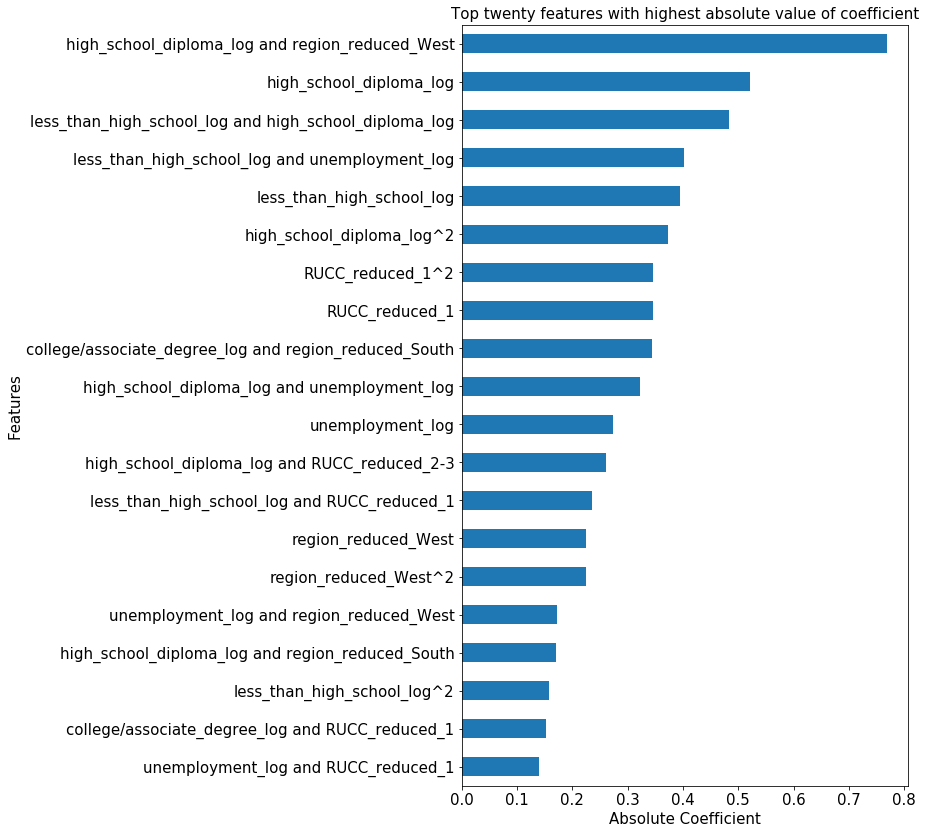

In [17]:
# Fit the pipeline on the entire dataset
pipeline.fit(X_train,y_train)

# Create list of features
feature_list = [feature.replace(' ',' and ') for feature in poly.get_feature_names(X_train.columns)]

# Create dataframe of feature coefficients
feature_df = pd.DataFrame(np.abs(pipeline.steps[2][1].coef_),columns=['coefficient'],index=feature_list)\
.sort_values(by='coefficient')

# Plot top 20 features with highest absolute value of coefficient
feature_df.iloc[-20:].plot.barh(figsize=(8,14),legend=False)
plt.xlabel('Absolute Coefficient',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Top twenty features with highest absolute value of coefficient',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.show()

In [23]:
#C=np.vstack([np.abs(pipeline.steps[2][1].coef_),pipeline.steps[2][1].coef_>0])
#pd.DataFrame(np.transpose(C),columns=['coefficient','Positive'],index=feature_list).sort_values(by='coefficient',ascending=False).iloc[:20]

#### Examine if the assumptions associated with linear models, i.e. linearity, equal variance of the errors, and normal distribution of errors are valid. To do so, draw residual vs. fitted values plot and quantile-quantile plot.

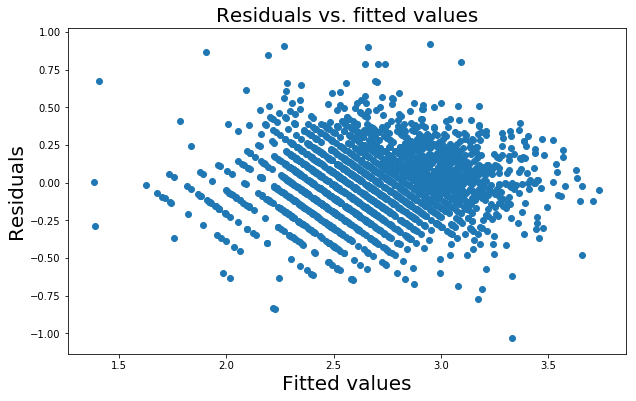

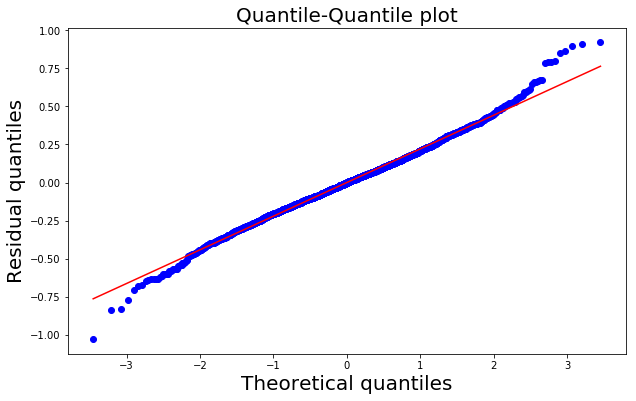

In [30]:
# Predict y for X_train
y_predict = pipeline.predict(X_train)
residuals = y_train - y_predict

# Plot residuals vs. fitted values
figure,ax = plt.subplots(figsize=(10,6))
ax.scatter(y_predict,residuals)
ax.set_xlabel('Fitted values',fontsize=20)
ax.set_ylabel('Residuals',fontsize=20);
ax.set_title('Residuals vs. fitted values',fontsize=20)

# Plot quantile-quantile plot
figure,ax = plt.subplots(figsize=(10,6))
stats.probplot(residuals,plot=ax)
ax.set_xlabel('Theoretical quantiles',fontsize=20)
ax.set_ylabel('Residual quantiles',fontsize=20)
ax.set_title('Quantile-Quantile plot',fontsize=20)
#ax.axis([-4,4,-35,35])

# Show plots
plt.show()

#### Observation

#### 1) residual vs. fitted values plot
#### 1.a) Linearity: The residuals bounce randomly around the 0 line. This suggests that the assumption of the linear relationship between features and target variable is reasonable.
#### 1.b) errors with equal variance: The residuals roughly form a horizontal band around the 0 line. This suggests the variances of the error terms are quite equal.

#### 2) Quantile-Quantile plot
#### Normal distribution of errors: The Quantile-Quantile plot shows the distribution of the residuals is close to the normal distribution except it is heavy tailed

### Build a support vector regressor

#### Run 5-fold cross-validation and average scores

In [13]:
# define the features DataFrame which contains the original format of the numerical features
X = df.loc[:,['less_than_high_school','high_school_diploma','college/associate_degree','unemployment',
              'RUCC_reduced','region_reduced']]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test(X,y,dummies=['RUCC_reduced_4-9','region_reduced_Northeast_Midwest'])

# Build the svr model. 
svr = SVR()

# Create a pipeline of scaler and svr
pipeline = make_pipeline(scaler,svr)

# Run cross-validation and print the average of scores
scores = cross_val_score(pipeline,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the support vector regressor with the original format of numerical\
 features is %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the support vector regressor with the original format of numerical features is 0.654


In [32]:
# The score for the logarithmic format of numerical features is 0.653
# The score for the original format of categorical features is 0.636

#### Tune hyper parameters

In [7]:
# Define a function which receives a regressor, its hyper parameters, X_train, and y_train, tune hyper parameters 
# and prints the best score and best parameters

def tuning(regressor,parameters,X_train,y_train):
    """This function receives a regressor, its hyper parameters, X_train, and y_train, tune hyper parameters 
    and prints the best score and best parameter values"""
    model = GridSearchCV(regressor,param_grid=parameters,cv=5)    
    model.fit(X_train,y_train)
    print('The best score in parameter tuning is: %.3f'%model.best_score_)
    print('The best parameters are: ',model.best_params_)    
    return model

In [10]:
# Build the svr model. Degree=2 will be only used if kernel='poly'
svr = SVR(degree=2)

# Define parameters
parameters = {'svr__C':np.logspace(-2,2,5),
              'svr__kernel': ['poly','linear','rbf'],
             'svr__gamma': ['auto','scale']}

# Tune hyper parameters of the svr
model = tuning(pipeline,parameters,X_train,y_train)

The best score in parameter tuning is: 0.654
The best parameters are:  {'svr__C': 1.0, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


### Develop a Random Forest model

#### Build a Random Forest without parameter tuning, run 5-fold cross-validation and average the scores.

In [35]:
# Build the model without parameter tuning. 
forest = RandomForestRegressor(random_state=21)

# There is no need to reduce the levels of categorical features or scale numerical features.

# define the features DataFrame which contains the original format of the numerical features
X = df.loc[:,['less_than_high_school','high_school_diploma','college/associate_degree','unemployment','RUCC','region']]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test(X,y,dummies=['region_Midwest','RUCC_9'])

# Run cross-validation, and average the scores
scores = cross_val_score(forest,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the random forest with original format of numerical features is\
 %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the random forest with original format of numerical features is 0.580


In [36]:
### The results are the same for the logarithmic format of the numerical features

#### Tune parameters of the random forest model. (min_samples_leaf lower than 5 could result in overfitting. Therefore, no value below 5 will be tested.)

In [37]:
# Define parameters
parameters = {'n_estimators':[50,80,100],
              'criterion': ['mse','mae'],
             'min_samples_leaf':[5,7,10],
             'max_features':['auto','sqrt','log2']}

# Tune hyper parameters of the random forest
model = tuning(forest,parameters,X_train,y_train)

The best score in parameter tuning is: 0.642
The best parameters are:  {'criterion': 'mse', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}


#### Fit the random forest model with tuned parameters to the entire train set. Then plot the feature importance diagram

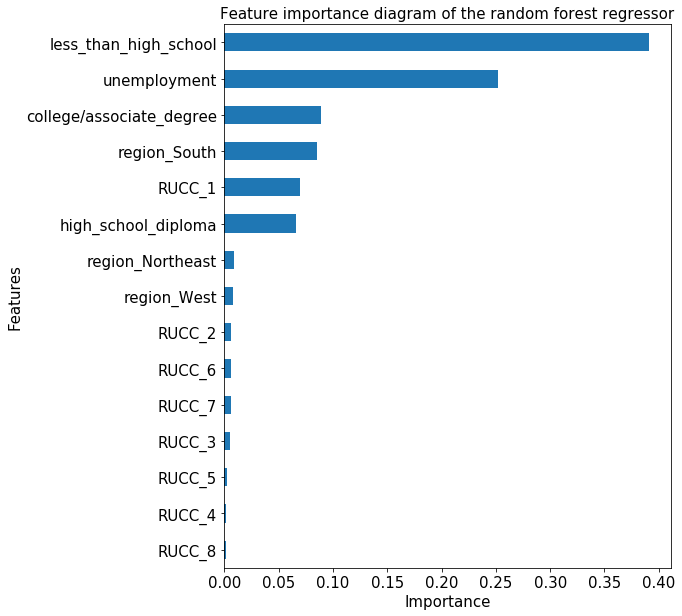

In [38]:
# Build the random forest with tuned parameters
forest = RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_leaf=5, n_estimators=50, random_state=21)

# Fit the random forest to the train set
forest.fit(X_train,y_train)

# Plot the feature importance diagram of top 20 most important features.
features = pd.DataFrame(forest.feature_importances_, index = X_train.columns,
                            columns=['importance']).sort_values('importance',ascending=True)

features.plot.barh(figsize=(8,10),legend = False)
plt.xlabel('Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title ('Feature importance diagram of the random forest regressor',fontsize=15)
plt.show()

### Build a XGBoost Regressor

#### Run 5-fold cross-validation and average scores

In [39]:
# Build the model without parameter tuning. 
xgb = XGBRegressor(random_state=21)

# There is no need to reduce the levels of categorical features and scale numerical features.

# define the features DataFrame which contains the original format of the numerical features
X = df.loc[:,['less_than_high_school','high_school_diploma','college/associate_degree','unemployment','RUCC','region']]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test(X,y,dummies=['region_Midwest','RUCC_9'])

# Run cross-validation, and average the scores
scores = cross_val_score(xgb,X_train,y_train,cv=5)
print('The average of 5-fold cross-validation scores for the XGBoost regressor with original format of numerical features is\
 %.3f'%np.mean(scores))

The average of 5-fold cross-validation scores for the XGBoost regressor with original format of numerical features is 0.643


#### Tune hyper parameters

In [40]:
# Define parameters
parameters = {'n_estimators':[50,80,100],
              'learning_rate':[0.05,0.1,0.2],
              'max_depth':[3,4,5],
              'subsample':[0.6,0.8,1],
             'colsample_bytree':[0.4,0.7,1]}

# Tune hyper parameters of the xgboost regressor
model = tuning(xgb,parameters,X_train,y_train)

The best score in parameter tuning is: 0.649
The best parameters are:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}


In [41]:
# Try more tuning on 'n_estimator' and 'subsample' since the best values are largest or smallest values 

# Build the model. 
xgb = XGBRegressor(random_state=21,colsample_bytree=1, learning_rate=0.1, max_depth=3)

# Define parameters
parameters = {'n_estimators':[100,200,500],
              'subsample':[0.3,0.45,0.6]}

# Tune hyper parameters of the xgboost regressor
model = tuning(xgb,parameters,X_train,y_train)

The best score in parameter tuning is: 0.649
The best parameters are:  {'n_estimators': 100, 'subsample': 0.6}


#### Fit the xgboost model with tuned parameters to the entire train set. Then plot the feature importance diagram

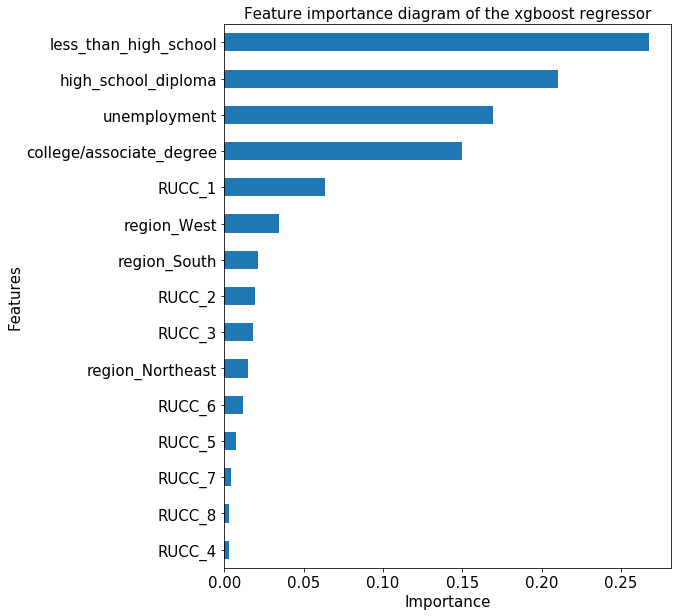

In [42]:
# Build the model. 
xgb = XGBRegressor(random_state=21,colsample_bytree=1, learning_rate=0.1, max_depth=3,n_estimator=100,subsample=0.6)

# Fit the regressor to the train set
xgb.fit(X_train,y_train)

# Plot the feature importance diagram of top 20 most important features.
features = pd.DataFrame(xgb.feature_importances_, index = X_train.columns,
                            columns=['importance']).sort_values('importance',ascending=True)

features.plot.barh(figsize=(8,10),legend = False)
plt.xlabel('Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title ('Feature importance diagram of the xgboost regressor',fontsize=15)
plt.show()

### Final Model and Test Set Score

### The support vector regressor has the highest average 5-fold cross-validation score, but its score is only 0.001 more than the score of the linear regression model with interaction terms. Since the linear model is more interpretable and easier to implement, it is selected as the final model.

In [43]:
# define the features DataFrame which contains the logarithmic format of the numerical features
X = df.loc[:,['less_than_high_school_log','high_school_diploma_log','college/associate_degree_log','unemployment_log',
              'RUCC_reduced','region_reduced']]

# Split data into train and test
X_train, X_test, y_train, y_test = train_test(X,y,dummies=['RUCC_reduced_4-9','region_reduced_Northeast_Midwest'])

# Create second-degree polynomial features and pipeline
linear = LinearRegression()
poly = PolynomialFeatures(degree = 2, interaction_only = False)
pipeline = make_pipeline(poly, scaler, linear)

# Fit the pipeline on the entire train set
pipeline.fit(X_train,y_train)

# Find the test score and print it
score = pipeline.score(X_test,y_test)
print('The test score for the linear model is %.3f'%score)

The test score for the linear model is 0.647


#### The test set score is only 1% less than the average 5-fold cross-validation score of the train set.